<center><h1>Making Predictions</h1></center>

In [1]:
import csv
import matplotlib.pyplot as plt
%matplotlib inline

from keras.preprocessing import sequence
from keras.models import Model, Sequential, model_from_json
from keras.layers import Dense, Dropout, Embedding, LSTM, Add, Bidirectional
import pandas as pd
import keras.layers
import keras
import numpy as np

Using TensorFlow backend.


### F0 prediction

In [2]:
# Load json and create model
json_file = open('f0model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model_f0 = model_from_json(loaded_model_json)
# Load weights into new model
loaded_model_f0.load_weights("f0model.h5")
print("Loaded model from disk")
 
# Compile loaded model with the same parameters
loaded_model_f0.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print("Compiled model")

Loaded model from disk
Compiled model


In [102]:
# Load data to classify
df1=pd.read_csv("/var/tmp/IA/features/MusicDelta_Reggae_features.csv",header=None)
X=pd.DataFrame.as_matrix(df1)
print (X.shape)

(1089, 513)


In [103]:
# Calculate predictions
predictions = loaded_model_f0.predict(X)

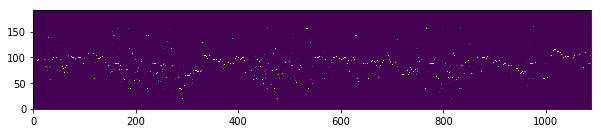

In [104]:
# Plot the grid
plt.figure(figsize=(10,6))
plt.imshow(np.transpose(predictions), origin='lower')
plt.show()

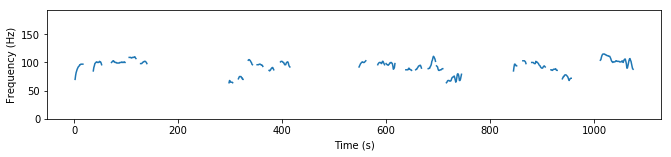

In [106]:
# Get labels to compare
annot = "/var/tmp/IA/labels/MusicDelta_Reggae_labels.csv"

labels = []

with open(annot) as csvfile:
    reader = csv.reader(csvfile)
    for row in reader:
        labels.append(float(row[0]))
        
for i in range(len(labels)):
    if labels[i] <= 0:
        labels[i] = None
        
# Plot melodic line from annotation
plt.figure(figsize=(11,2))
axes = plt.gca()
axes.set_ylim([0,193])
plt.plot(labels[::2])
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.show()

In [7]:
# The comparision is done with the labels precalculated, so it is necessary compare directly.

In [107]:
# Max probability line
ynotes = np.argmax(np.transpose(predictions), axis=0)

In [108]:
#https://jyyuan.wordpress.com/2014/01/22/viterbi-algorithm-finding-most-likely-sequence-in-hmm/
# classes/functions go here
def viterbi_alg(A_mat, O_mat, observations):
    # get number of states
    num_obs = observations.size
    num_states = A_mat.shape[0]
    # initialize path costs going into each state, start with 0
    log_probs = np.zeros(num_states)
    # initialize arrays to store best paths, 1 row for each ending state
    paths = np.zeros( (num_states, num_obs+1 ))
    paths[:, 0] = np.arange(num_states)
    # start looping
    for obs_ind, obs_val in enumerate(observations):
        # for each obs, need to check for best path into each state
        for state_ind in range(num_states):
            # given observation, check prob of each path
            temp_probs = log_probs + \
                         np.log(O_mat[state_ind, obs_val]) + \
                         np.log(A_mat[:, state_ind])
            # check for largest score
            best_temp_ind = np.argmax(temp_probs)
            # save the path with a higher prob and score
            paths[state_ind,:] = paths[best_temp_ind,:]
            paths[state_ind,(obs_ind+1)] = state_ind
            log_probs[state_ind] = temp_probs[best_temp_ind]
    # we now have a best stuff going into each path, find the best score
    best_path_ind = np.argmax(log_probs)
    # done, get out.
    return (best_path_ind, paths, log_probs)

In [109]:
trans_mtx = np.ones((193 ,193))
for k in range(193):
    for l in range(193):
        trans_mtx[k][l] = 1/abs(k-l+0.1)
print (trans_mtx)


[[  1.00000000e+01   1.11111111e+00   5.26315789e-01 ...,   5.26592944e-03
    5.23834468e-03   5.21104742e-03]
 [  9.09090909e-01   1.00000000e+01   1.11111111e+00 ...,   5.29380625e-03
    5.26592944e-03   5.23834468e-03]
 [  4.76190476e-01   9.09090909e-01   1.00000000e+01 ...,   5.32197978e-03
    5.29380625e-03   5.26592944e-03]
 ..., 
 [  5.26038927e-03   5.28820730e-03   5.31632111e-03 ...,   1.00000000e+01
    1.11111111e+00   5.26315789e-01]
 [  5.23286238e-03   5.26038927e-03   5.28820730e-03 ...,   9.09090909e-01
    1.00000000e+01   1.11111111e+00]
 [  5.20562207e-03   5.23286238e-03   5.26038927e-03 ...,   4.76190476e-01
    9.09090909e-01   1.00000000e+01]]


In [110]:
# Make the signal smooth (Lower Raw Pitch Accuracy)
#ynotes = scipy.signal.medfilt(np.argmax(np.transpose(predictions), axis=0).tolist(), 5)

best_path_ind, paths, log_probs = viterbi_alg(trans_mtx, trans_mtx, ynotes)
print ("obs1 is " + str(ynotes))
print ("obs1, best path is" + str(paths[best_path_ind,:]))

obs1 is [70 74 79 ..., 93 88 88]
obs1, best path is[ 69.  72.  76. ...,  88.  88.  89.]


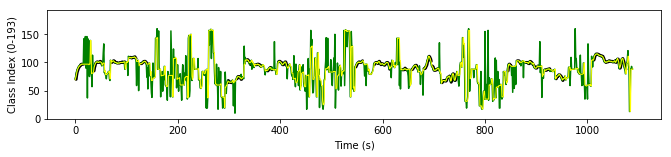

In [111]:
# Plot melodic line from annotation and result
plt.figure(figsize=(11,2))
axes = plt.gca()
axes.set_ylim([0,193])
plt.plot(labels[::2], solid_capstyle="round", linewidth=3, color='black')
plt.plot(ynotes, solid_capstyle="round", linewidth=1.5, color='green')
plt.plot(paths[best_path_ind,:], solid_capstyle="round", linewidth=1, color='yellow')
plt.xlabel('Time (s)')
plt.ylabel('Class Index (0-193)')
plt.show()

### Measures

In [112]:
# RAW PITCH ACCURACY (error less than a half of a semitone)
# How the classes are done for represent an eight of tone, if the error of estimation
# is in the range {f0-2, f0+2}, the estimation is correct. res = ynotes
lbl = labels[::2]
res = ynotes
acc = 0
vstar = 0

for j in range(len(ynotes)):
    if lbl[j] is not None:
        vstar += 1
        if res[j] >= lbl[j]-2 and res[j] <= lbl[j]+2:
            acc += 1
    
print ("Raw Pitch Accuracy:", acc/vstar)    

Raw Pitch Accuracy: 0.7248803827751196


In [113]:
# RAW PITCH ACCURACY (error less than a half of a semitone)
# How the classes are done for represent an eight of tone, if the error of estimation
# is in the range {f0-2, f0+2}, the estimation is correct. res = ynotes
lbl = labels[::2]
res = paths[best_path_ind,:]
acc = 0
vstar = 0

for j in range(len(ynotes)):
    if lbl[j] is not None:
        vstar += 1
        if res[j] >= lbl[j]-2 and res[j] <= lbl[j]+2:
            acc += 1
    
print ("Raw Pitch Accuracy:", acc/vstar)    

Raw Pitch Accuracy: 0.916267942583732


### SVDMODEL

In [15]:
# load json and create model
json_file = open('SVDmodel.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model_svd = model_from_json(loaded_model_json)
# load weights into new model
loaded_model_svd.load_weights("SVDmodel.h5")
print("Loaded model from disk")

# compile loaded model with the same parameters
loaded_model_svd.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print("Compiled model")

Loaded model from disk
Compiled model


In [114]:
# Load data to classify
df1 = pd.read_csv("/var/tmp/IA/mfcc/MusicDelta_Reggae_mfcc.csv",header=None)
X = pd.DataFrame.as_matrix(df1)
print (X.shape)

(2177, 120)


In [115]:
# Data Normalization (this step makes me worried =/)
X.max()
meanDF = X - np.mean(X, axis=0).reshape(1, X.shape[1])
X  = meanDF / np.std(meanDF, axis=0).reshape(1, X.shape[1])
np.std(X, axis=0)

array([ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.])

In [116]:
# calculate predictions
voiced = loaded_model_svd.predict(X)
print(voiced)

[[ 0.58979774]
 [ 0.79136407]
 [ 0.77331758]
 ..., 
 [ 0.12962548]
 [ 0.12962548]
 [ 0.12962545]]


In [117]:
X[0].std()

0.70192832007328021

In [118]:
print (np.max(voiced), np.min(voiced))

0.992105 0.0471034


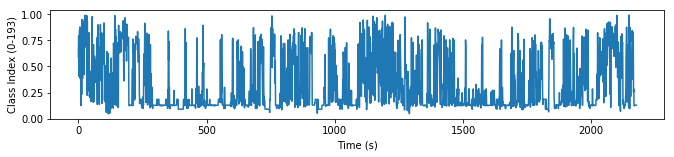

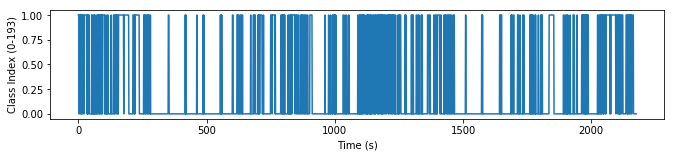

In [119]:
# Plot melodic line from annotation
plt.figure(figsize=(11,2))
plt.plot(voiced)
plt.xlabel('Time (s)')
plt.ylabel('Class Index (0-193)')
plt.show()

# Activation output - need to be 0.5
vcd = voiced.copy()
vcd[vcd <  0.5] = 0
vcd[vcd >= 0.5] = 1

# Plot melodic line from annotation
plt.figure(figsize=(11,2))
plt.plot(vcd)
plt.xlabel('Time (s)')
plt.ylabel('Class Index (0-193)')
plt.show()

# How to make it smooth???

In [120]:
# Activation output - need to be 0.5
vcd = voiced.copy()
vcd[vcd <  0.5] = 0
vcd[vcd >= 0.5] = 1

### Measures

In [121]:
# We have the same value of voiced frames and labeled frames!!!
vocal = vcd

TN, TP, FN, FP = 0, 0, 0, 0

res = vocal.copy()
lbl = labels.copy()

for j in range(len(vocal)):
    if res[j] == 0:
        res[j] = None
        if lbl[j] == res[j]:
            TN += 1
        else:
            FN += 1

    if lbl[j] is not None:
        lbl[j] = 1
        if lbl[j] == res[j]:
            TP += 1
    
    elif res[j] == 1:
        FP += 1

/usr/lib/python3/dist-packages/ipykernel/__main__.py:12: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


In [122]:
print ("Precision", TP/(TP+FP))
print ("Recall", TP/(TP+FN))
print ("Voicing Recall Rate:", TP/(TP+FN))
print ("Voicing False Alarm Rate:", FP/(TN+FP))  

Precision 0.6672240802675585
Recall 0.20171890798786654
Voicing Recall Rate: 0.20171890798786654
Voicing False Alarm Rate: 1.0


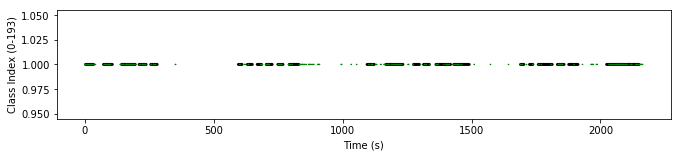

In [123]:
# Plot melodic line from annotation
plt.figure(figsize=(11,2))
plt.plot(lbl, solid_capstyle="round", linewidth=3, color='black')
plt.plot(res, solid_capstyle="round", linewidth=1.5, color='green')
plt.xlabel('Time (s)')
plt.ylabel('Class Index (0-193)')
plt.show()

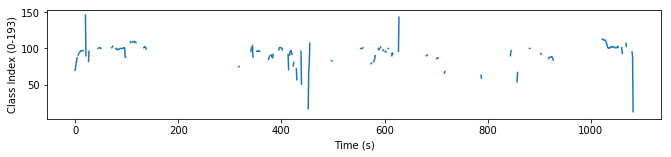

In [124]:
# We have doubled vocal answers
fim = []

for j in range(len(ynotes)):
    fim.append(res[::2][j]*float(ynotes[j]))
    if fim[j] == 0:
        fim[j] = None

# Plot melodic line from annotation
plt.figure(figsize=(11,2))
plt.plot(fim)
plt.xlabel('Time (s)')
plt.ylabel('Class Index (0-193)')
plt.show()

In [35]:
from keras.initializers import RandomNormal
from keras import optimizers
max_features = 120
hidden_neurons = 50
maxlen = 120
batch_size = 1000
# create model
print("Create model...")
model = Sequential()
model.add(Embedding(max_features, 50, input_length=maxlen))
model.add(Bidirectional(LSTM(50, return_sequences=True, kernel_initializer = RandomNormal(mean = 0, stddev = 0.1))))
model.add(Bidirectional(LSTM(50, return_sequences=True, kernel_initializer = RandomNormal(mean = 0, stddev = 0.1))))
model.add(Bidirectional(LSTM(50, kernel_initializer = RandomNormal(mean = 0, stddev = 0.1))))
#model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

# Compile model
# 20 epochs without change
sgd = optimizers.SGD(lr=10e-7, momentum=0.9)
model.compile(loss='binary_crossentropy', metrics=['accuracy'], optimizer=sgd)

Create model...


In [36]:
# calculate predictions
voiced2 = model.predict(X)
print(voiced2)

[[ 0.50197756]
 [ 0.50236267]
 [ 0.50237697]
 ..., 
 [ 0.50223285]
 [ 0.50223285]
 [ 0.50223285]]


In [37]:
# Activation output - need to be 0.5
vcd = voiced2.copy()
vcd[vcd <  0.5] = 0
vcd[vcd >= 0.5] = 1

### Measures

In [38]:
# We have the same value of voiced frames and labeled frames!!!
vocal = vcd

TN, TP, FN, FP = 0, 0, 0, 0

res = vocal.copy()
lbl = labels.copy()

for j in range(len(vocal)):
    if res[j] == 0:
        res[j] = None
        if lbl[j] == res[j]:
            TN += 1
        else:
            FN += 1

    if lbl[j] is not None:
        lbl[j] = 1
        if lbl[j] == res[j]:
            TP += 1
    
    elif res[j] == 1:
        FP += 1

In [39]:
print ("Precision", TP/(TP+FP))
print ("Recall", TP/(TP+FN))
print ("Voicing Recall Rate:", TP/(TP+FN))
print ("Voicing False Alarm Rate:", FP/(TN+FP))  

Precision 0.3853927423059256
Recall 1.0
Voicing Recall Rate: 1.0
Voicing False Alarm Rate: 1.0


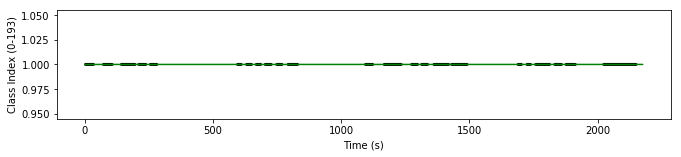

In [40]:
# Plot melodic line from annotation
plt.figure(figsize=(11,2))
plt.plot(lbl, solid_capstyle="round", linewidth=3, color='black')
plt.plot(res, solid_capstyle="round", linewidth=1.5, color='green')
plt.xlabel('Time (s)')
plt.ylabel('Class Index (0-193)')
plt.show()

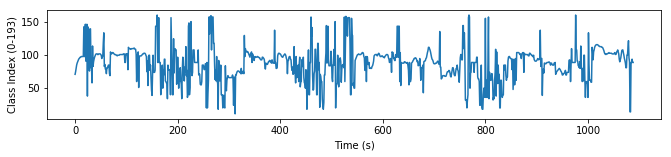

In [41]:
# We have doubled vocal answers
res = []

for j in range(len(ynotes)):
    res.append(int(vocal[j]*float(ynotes[j])))
    if res[j] == 0:
        res[j] = None

# Plot melodic line from annotation
plt.figure(figsize=(11,2))
plt.plot(res)
plt.xlabel('Time (s)')
plt.ylabel('Class Index (0-193)')
plt.show()